## CNN Cancer Detection Kaggle Mini-Project

This Jupyter notebook implements a convolutional neural network (CNN) for histopathologic cancer detection using TensorFlow with GPU acceleration. Here's the structured analysis:

#### Problem Description & Data
**Task:**

Binary classification of 96x96px image patches to identify metastatic breast cancer in lymph node tissue.

**Dataset:**

Contains 220,025 training images (Kaggle competition data) with labels:

0: No tumor tissue present

1: At least one tumor pixel in center 32x32px region

**Class Distribution**:

Initial samples show 3/5 negative cases and 2/5 positive cases, suggesting potential class imbalance

In [1]:
# GPU Setup
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
#imports
import pandas as pd
import numpy as np
import os
from numpy.random import seed
seed(102)

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
tf.random.set_seed(102)

import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import shutil
%matplotlib inline
from PIL import Image

In [3]:
from tensorflow.keras import layers, models, callbacks

In [4]:
#first look at the data
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Configuration

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64  # Reduced for P400's 8GB VRAM
IMG_SIZE = 96
N_CLASSES = 1
EPOCHS = 15  # Increased to compensate for smaller batches

### Data Preparation

In [6]:
#train_df['id'] = train_df['id'].apply(lambda x: f'{x}.tif')
train_df['id'] = train_df['id'].astype(str) + '.tif'
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [30]:
test_df = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')

In [31]:
len(test_df)

57458

In [32]:
test_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [9]:
"""# Class Weighting
neg, pos = np.bincount(train_df['label'])
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)"""

"# Class Weighting\nneg, pos = np.bincount(train_df['label'])\ntotal = neg + pos\nweight_for_0 = (1 / neg) * (total / 2.0)\nweight_for_1 = (1 / pos) * (total / 2.0)\nclass_weight = {0: weight_for_0, 1: weight_for_1}\nprint(class_weight)"

### Exploratory Data Analysis

In [10]:
import pathlib

train_path = '/kaggle/input/histopathologic-cancer-detection/train'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

train_dir = pathlib.Path(train_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('') #path object to the test_dir

trn_img_paths = list(train_dir.glob('*.tif'))
tst_img_paths = list(test_dir.glob('*.tif')) 

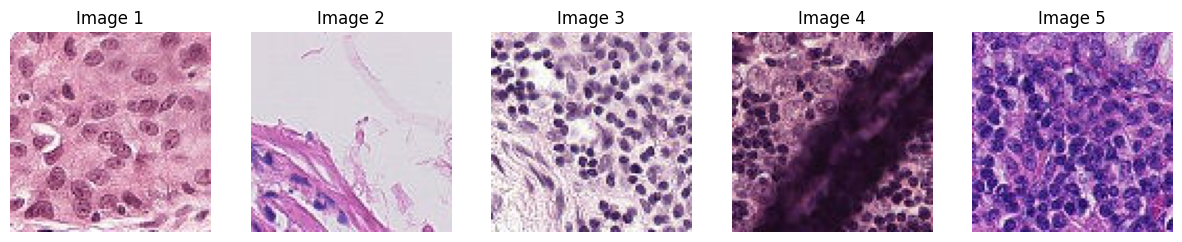

In [11]:
from PIL import Image

# Function to display images
def display_images(image_paths, num_images=5):
    plt.figure(figsize=(15, 15))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

# Display the first 5 images
display_images(trn_img_paths, num_images=5)

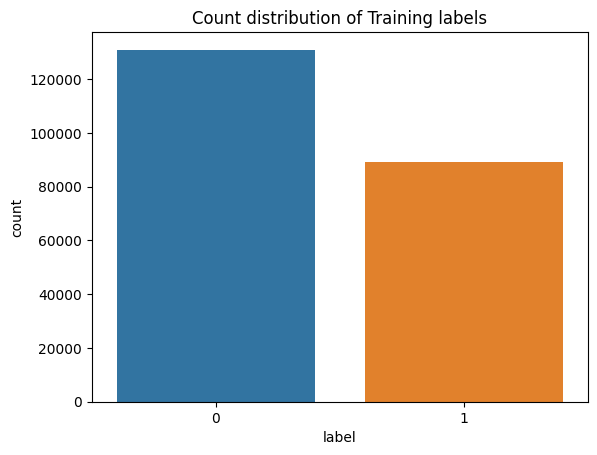

In [12]:
#Visualizing Class Distribution
sns.countplot(x = 'label',data=train_df)
plt.title('Count distribution of Training labels')
plt.show()

## Data Augmentation and Data Preprocessing:
I will create 'train_datagen' and 'val_datagen' to create separate data generators for the training and validation sets. They will be initialized with the same parameters. Having separate generators allows for flexibility in applying different data augmentation techniques or preprocessing steps to the training and validation sets.

In [13]:
#train_df['label'] = train_df['label'].astype(int)

In [14]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [15]:
#seperate the labels
pos_labels = train_labels[train_labels['label']==1]
neg_labels = train_labels[train_labels['label']==0]

#sample and shuffle the labels
train_pos = pos_labels.sample(20000,random_state=42)
train_neg = neg_labels.sample(20000,random_state=42)

train_df = pd.concat([train_pos,train_neg])

train_shuffle_df = shuffle(train_df, random_state=42).reset_index(drop=True)
train_shuffle_df.shape


(40000, 2)

In [16]:
train_shuffle_df.head()

,id,label
0,49ad2195c04dc40625cb578cc233fc44deb6cca1,0
1,6f70bbb436e3b6ac1b667beb2e42eab23ef54959,1
2,c302a5e382e40dd3963e0202c5ae60dd096dfe3f,0
3,96f01a14d4724a2b028cc68e46adce3a20f78d05,1
4,bf866de062fe8ab44d89acecf3386cf7974bd863,0


In [17]:
"""train_shuffle_df.id = train_shuffle_df.id + '.tif'
train_shuffle_df.label = train_shuffle_df.label.astype(str)
train_shuffle_df.head()"""
train_shuffle_df.id = train_shuffle_df.id + '.tif'

In [18]:
# Optimized Data Pipeline
def create_datagen():
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        zoom_range=0.15
    )

train_datagen = create_datagen()

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_shuffle_df,
    directory='../input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='training',
    shuffle=True,
    
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_shuffle_df,
    directory='../input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='validation',
    
)

Found 32000 validated image filenames.
Found 8000 validated image filenames.


In [19]:
# GPU-Optimized Model
def build_model():
    model = Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(N_CLASSES, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_model()

# Callbacks
callbacks = [
    ModelCheckpoint('best_model.keras', 
                   monitor='val_loss',
                   save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', 
                     factor=0.5, 
                     patience=2),
    EarlyStopping(monitor='val_auc',
                 patience=5,
                 mode='max',
                 restore_best_weights=True)
]

In [21]:
# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    #class_weight=class_weight
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 368s 712ms/step - accuracy: 0.7582 - auc: 0.8325 - loss: 0.4992 - val_accuracy: 0.7231 - val_auc: 0.8270 - val_loss: 0.5383 - learning_rate: 1.0000e-04
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 148s 292ms/step - accuracy: 0.8240 - auc: 0.9024 - loss: 0.3963 - val_accuracy: 0.8354 - val_auc: 0.9175 - val_loss: 0.3707 - learning_rate: 1.0000e-04
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 148s 292ms/step - accuracy: 0.8363 - auc: 0.9110 - loss: 0.3791 - val_accuracy: 0.8425 - val_auc: 0.9221 - val_loss: 0.3612 - learning_rate: 1.0000e-04
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 289ms/step - accuracy: 0.8456 - auc: 0.9210 - loss: 0.3575 - val_accuracy: 0.8514 - val_auc: 0.9299 - val_loss: 0.3421 - learning_rate: 1.0000e-04
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 148s 292ms/step - accuracy: 0.8508 - auc: 0.9276 - loss: 0.3432 - val_accuracy: 0.8644 - val_auc: 0.9379 - val_loss: 0.3224 - learning_rate: 1.0000e-04
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 147s 292ms/

## Evaluation

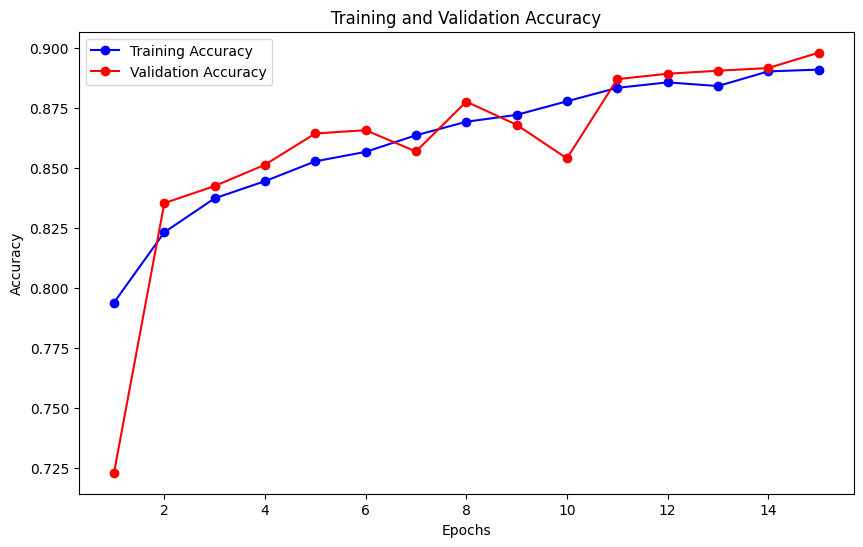

In [41]:
# Extract accuracy values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


From the above plot we see how the training and validation accuracies vary at each epoch. At the end of 15 epochs, both are around an accuracy of 89%. Accuracy is a common and intuitive metric used in classification tasks, but it’s not always the most informative or relevant, especially in certain situations. In our case, we need to look at Precision and Recall as well. 

### Importance of Precision and Recall in Classification tasks: 

In [45]:
train_filenames = train_generator.filenames  # Extract filenames
train_steps = train_generator.samples // train_generator.batch_size

# Reset the generator and predict to ensure it is in the correct state
train_generator.reset()

# Assuming 'train_labels' are the true labels from the generator
train_labels = []
for i in range(train_steps):
    batch = train_generator[i]
    labels = batch[1]  # Extract labels from the batch
    train_labels.extend(labels)

# Create training DataFrame with filenames and true labels
train_df = pd.DataFrame({
    'id': train_filenames,
    'true_label': train_labels
})

print(train_df.head())


                                             id  true_label
0  b365511690e16cb986d1e5631e91fd4f206fb0c4.tif           0
1  af4db7948fffab25967d8a088cd3ede6db580579.tif           1
2  70fb28bed222fe64ffde63014ed07dfa48174c32.tif           0
3  e3edff30d87252d63abad1fa9123bbccec8db0e5.tif           0
4  a06f33735a0c444725a274724216b261f4f296ed.tif           1


In [46]:
len(train_df)

32000

In [48]:
train_predictions = model.predict(train_generator, steps=train_steps)

# Binarize the predictions
train_pred_labels = (train_predictions > 0.5).astype(int)
train_true_labels = train_df['true_label'].values[:len(train_pred_labels)] 

500/500 ━━━━━━━━━━━━━━━━━━━━ 115s 230ms/step


In [49]:
from sklearn.metrics import precision_score, recall_score

# Calculate precision and recall
train_precision = precision_score(train_true_labels, train_pred_labels)
train_recall = recall_score(train_true_labels, train_pred_labels)

print(f'Training Precision: {train_precision}')
print(f'Training Recall: {train_recall}')


Training Precision: 0.916759374386493
Training Recall: 0.8763292881271112


The training precision and recall scores are high enough. Precision is at 91% and Recall is at 87%. But, it's important to look at validation precision and recall scores because we need to flag flase negatives and false positives. False negatives are more important here as getting a false negative implies the patient's cancer diagnosis is falsely detected as negative. In this case, the patient may not get the timely treatment, which is of at most importance when it comes to cancer.

In [43]:
val_filenames = val_generator.filenames  # Extract filenames
val_steps = val_generator.samples // val_generator.batch_size

# Reset the generator and predict to ensure it is in the correct state
val_generator.reset()
val_predictions = model.predict(val_generator, steps=val_steps)

# Assuming 'val_labels' are the true labels from the generator
val_labels = []
for i in range(val_steps):
    batch = val_generator[i]
    labels = batch[1]  # Extract labels from the batch
    val_labels.extend(labels)

# Create validation DataFrame with filenames and true labels
validation_df = pd.DataFrame({
    'id': val_filenames,
    'true_label': val_labels
})

print(validation_df.head())

125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step
                                             id  true_label
0  49ad2195c04dc40625cb578cc233fc44deb6cca1.tif           0
1  6f70bbb436e3b6ac1b667beb2e42eab23ef54959.tif           1
2  c302a5e382e40dd3963e0202c5ae60dd096dfe3f.tif           1
3  96f01a14d4724a2b028cc68e46adce3a20f78d05.tif           1
4  bf866de062fe8ab44d89acecf3386cf7974bd863.tif           0


In [50]:
# Binarize the predictions
val_pred_labels = (val_predictions > 0.5).astype(int)

# Calculate precision and recall
precision = precision_score(val_labels, val_pred_labels)
recall = recall_score(val_labels, val_pred_labels)

print(f'Precision: {precision}')
print(f'Recall: {recall}')


Precision: 0.499341585462207
Recall: 0.47234678624813153


Precision at 50% and recall at 47% for the validation dateset. This is a very low score and can have very bad consequences in real world applications. This implies that the model is underperforming and it needs better training.

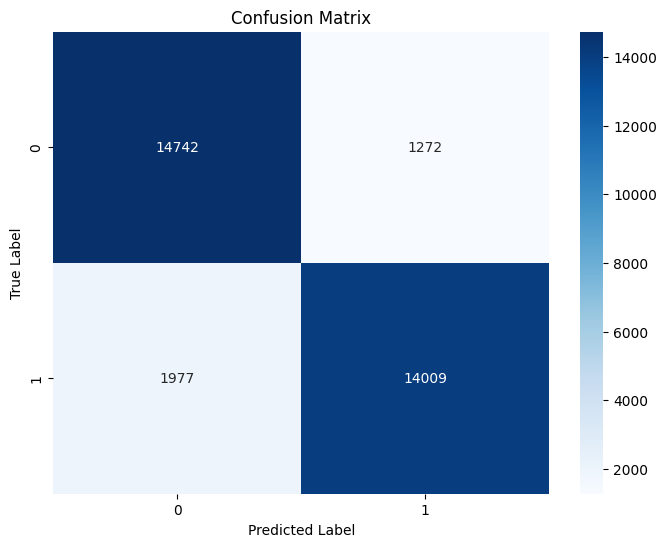

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Construct confusion matrix
conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

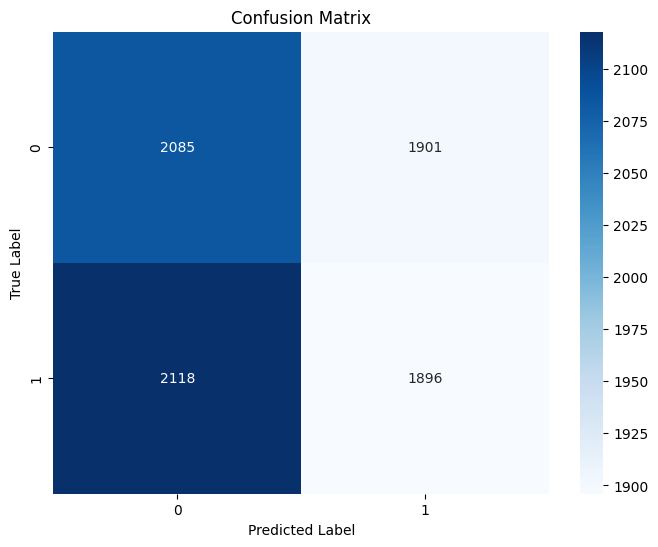

In [52]:
# Construct confusion matrix validation data
conf_matrix = confusion_matrix(val_labels, val_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Conclusion:

Class Imbalance: If dataset has a significant imbalance between positive (cancer) and negative (no cancer) cases, model might be biased towards predicting the majority class. This can lead to low recall (missing positive cases) and low precision (misclassifying negative cases as positive).

Overfitting: Model might be overfitting to the training data, performing well on it but poorly on the validation set. Overfitting can reduce the model's generalization capability.

Model Complexity: The chosen model architecture might be too simple or too complex for the task. A simple model might not capture enough patterns, while a complex one might overfit the training data.

## Improvements that cane be considered:

**Class Weighting:**

Use class weights to address class imbalance. You can assign a higher weight to the minority class (positive cases) to ensure the model pays more attention to them.

**Model Architecture:**

Experiment with different model architectures. Try using pre-trained models (transfer learning) like ResNet, VGG, or EfficientNet, which are often more effective for image classification tasks.

**Hyperparameter Tuning:**

Perform hyperparameter tuning to find the best settings for your model. You can use techniques like grid search or random search to explore different hyperparameters.

**Regularization:**

Add regularization techniques such as dropout, L2 regularization, or early stopping to prevent overfitting.

**Cross-Validation:**

Implement cross-validation to ensure that your model's performance is consistent across different subsets of your data.

**Feature Engineering:**

If your model allows it, perform feature engineering to extract more informative features from the images.

In [37]:
test_df['id'] = test_df['id'].astype(str) + '.tif' 

In [38]:
test_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [39]:

# Prediction
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='../input/histopathologic-cancer-detection/test/',
    x_col='id',
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

probs = model.predict(test_generator)
test_df['label'] = (probs > 0.5).astype(int)
#test_df.to_csv('submission.csv', index=False)

Found 57458 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 319s 355ms/step


In [40]:
test_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [ ]:
test_df['id'] = test_df['id'].str.replace('.tif', '', regex=False)

# Verify correction
print(test_df.head())

In [ ]:
test_df.to_csv('/kaggle/working/submission.csv', index=False)